In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from skimage.feature import hog
from scipy.ndimage.measurements import label
from features import *
%matplotlib inline
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [2]:
# uncomment if you want to run find_cars() for still images outside of track_vehicles()

# model_pickle = pickle.load(open('00-training.pkl', 'rb'))
# svc = model_pickle['svc']
# X_scaler = model_pickle['scaler']
# orient = model_pickle['orient']
# pix_per_cell = model_pickle['pix_per_cell'] 
# cell_per_block = model_pickle['cell_per_block']
# spatial_size = model_pickle['spatial_size']
# hist_bins = model_pickle['hist_bins']

In [3]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

In [4]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

In [5]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [6]:
def draw_labeled_bboxes(img, labels):
    box_list = []
    
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        # could be [0,255] or [0,1] depending how the file was read in
        cv2.rectangle(img, bbox[0], bbox[1], (255,0,0), 6)
        
        box_list.append(bbox)

    return img, box_list

In [17]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    #draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    bboxes = []
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bboxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
                #if you want to draw hog subsampling boxes
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
    
    #add up heat overlap 
    heatmap = add_heat(heat, bboxes)
                
    return heatmap, bboxes #, draw_img

In [18]:
def track_vehicles(img):
    
    global draw_img_prev, bbox_list_prev, labels_prev, heatmap_sum
    global first_frame, frame_count
    
    model_pickle = pickle.load(open('00-training.pkl', 'rb'))
    svc = model_pickle['svc']
    X_scaler = model_pickle['scaler']
    orient = model_pickle['orient']
    pix_per_cell = model_pickle['pix_per_cell'] 
    cell_per_block = model_pickle['cell_per_block']
    spatial_size = model_pickle['spatial_size']
    hist_bins = model_pickle['hist_bins']
    
    #this could be changed relative to image size
    ystart = 400
    ystop = 420
    
    if first_frame:
        
        #initialize the running average heatmap
        heatmap_sum = np.zeros_like(img[:,:,0]).astype(np.float)
        
        for scale in (1.0,1.5,2.0):
            
            #as the image scale gets bigger, the ROI needs to extend
            ystop = ystop + 75

            heatmap, bboxes = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, 
                                        pix_per_cell, cell_per_block, spatial_size, hist_bins)
            #sum up heatmap for all scales
            heatmap_sum = np.add(heatmap_sum,heatmap)
        
        heatmap = apply_threshold(heatmap_sum, 2)
        heatmap = np.clip(heatmap, 0, 1)
        labels = label(heatmap)
        draw_img, bbox_list = draw_labeled_bboxes(np.copy(img), labels)

        draw_img_prev = draw_img
        bbox_list_prev = bbox_list
        labels_prev = labels

        first_frame = False
    
        return draw_img
    
    if frame_count <= 2:
        
        frame_count += 1
        
        #reset ROI
        ystop = 420
        
        for scale in (1.0,1.5,2.0):

            ystop = ystop + 75
            heatmap, bboxes = find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                                            orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
            heatmap_sum = np.add(heatmap_sum,heatmap)
            draw_img = np.copy(img)
        
        #draw old boxes
        for unique_car in range(1, labels_prev[1]+1):
            draw_img = cv2.rectangle(draw_img, bbox_list_prev[unique_car-1][0],
                                     bbox_list_prev[unique_car-1][1], (255,0,0), 6)
        return draw_img
    
    heatmap = apply_threshold(heatmap_sum,2)
    heatmap = np.clip(heatmap, 0, 255)
    labels = label(heatmap)   
    draw_img, bbox_list = draw_labeled_bboxes(np.copy(img), labels)   
    
    draw_img_prev = draw_img
    bbox_list_prev = bbox_list
    labels_prev = labels
    
    #reset heatmap sum and frame_count
    heatmap_sum = np.zeros_like(img[:,:,0]).astype(np.float)
    frame_count = 0
    
    return draw_img

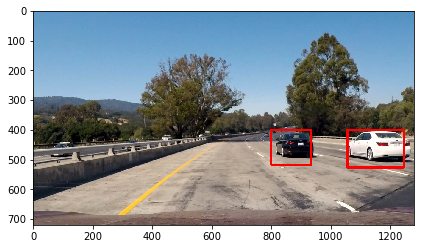

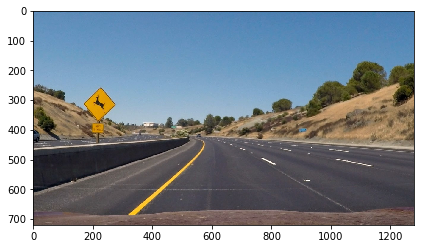

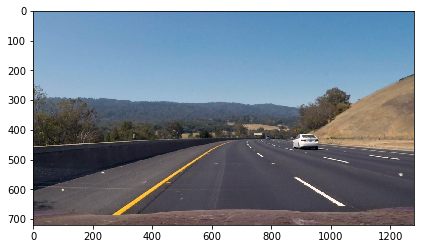

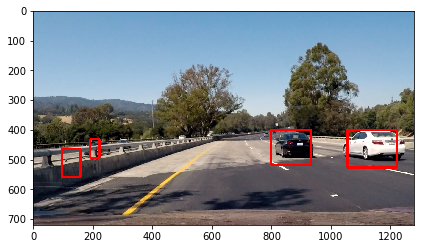

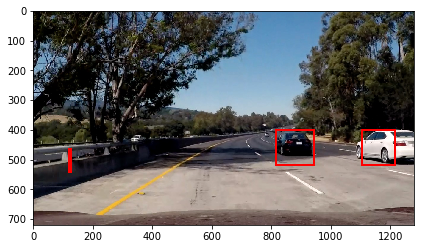

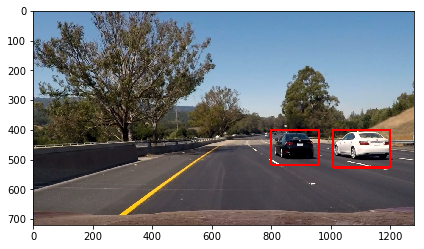

In [19]:
import glob
images = glob.glob('test_images/*jpg')
for index, image in enumerate(images):
    img = mpimg.imread(image)
    global first_frame, frame_count
    frame_count = 0
    first_frame = True
    draw = track_vehicles(img)
    plt.figure()
    plt.imshow(draw);
    plt.tight_layout()
    plt.savefig('output_images{}'.format(index))

In [20]:
global first_frame, frame_count
frame_count = 0
first_frame = True

project_video_output = 'combined_pipeline.mp4'
clip2 = VideoFileClip('processed-project_video.mp4')

project_video_clip = clip2.fl_image(track_vehicles)
%time project_video_clip.write_videofile(project_video_output, audio=False, verbose=False)

100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [07:18<00:00,  2.87it/s]


Wall time: 7min 19s


In [21]:
video = 'combined_pipeline.mp4'
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video))

In [ ]:
# NEXT STEPS
# How fast does this run without editing the images at all, just returning calculations? Does it run in realtime? 
# Can my phone process this in realtime?
# 
# YOLO and SSD on computer AND/OR Android APK 